[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/danpele/Time-Series-Analysis/blob/main/chapter10_lecture_notebook.ipynb)

---

# Chapter 10: Comprehensive Review

**Complete Time Series Analysis with Real Data**

**Course:** Time Series Analysis and Forecasting  
**Program:** Bachelor program, Faculty of Cybernetics, Statistics and Economic Informatics, Bucharest University of Economic Studies, Romania  
**Academic Year:** 2025-2026

---

## Learning Objectives

This comprehensive review demonstrates the complete time series analysis workflow using **real data** with proper **train/validation/test** methodology:

1. **Case Study 1: Bitcoin** - ARIMA-GARCH with proper volatility forecasting evaluation
2. **Case Study 2: Sunspots** - Long-cycle seasonal data with cross-validation
3. **Case Study 3: US Unemployment** - Structural breaks with Prophet
4. **Case Study 4: Multivariate Analysis** - VAR model with Granger causality

### Key Methodology: Train/Validation/Test Split

```
|<------ Training ------>|<-- Validation -->|<---- Test ---->|
|                        |                  |                |
|  Fit model parameters  | Select hyperpar. | Final evaluate |
|                        | Compare models   | Report metrics |
```

**Why this matters:**
- **Training set**: Used to estimate model parameters
- **Validation set**: Used to select hyperparameters and compare models
- **Test set**: Held out until the very end for unbiased final evaluation

## Setup and Imports

In [1]:
# Install required packages (for Colab)
import sys
if 'google.colab' in sys.modules:
    !pip install prophet arch statsmodels yfinance pandas-datareader -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Statistical tests and models
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose

# GARCH
try:
    from arch import arch_model
    HAS_ARCH = True
except ImportError:
    HAS_ARCH = False
    print("arch not installed. Install with: pip install arch")

# Prophet
try:
    from prophet import Prophet
    HAS_PROPHET = True
except ImportError:
    HAS_PROPHET = False
    print("Prophet not installed. Install with: pip install prophet")

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Plotting style - CONSISTENT WITH OTHER CHAPTERS
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['legend.frameon'] = False

COLORS = {'blue': '#1A3A6E', 'red': '#DC3545', 'green': '#2E7D32', 
          'orange': '#E67E22', 'gray': '#666666', 'purple': '#8E44AD'}

print("Setup complete!")
print(f"ARCH/GARCH available: {HAS_ARCH}")
print(f"Prophet available: {HAS_PROPHET}")

Prophet not installed. Install with: pip install prophet
Setup complete!
ARCH/GARCH available: True
Prophet available: False


## Helper Functions

In [2]:
def test_stationarity(series, name):
    """Run ADF and KPSS tests for stationarity"""
    print(f"\nStationarity Tests for {name}")
    print("-" * 50)
    
    # ADF Test (H0: unit root exists = non-stationary)
    adf_result = adfuller(series.dropna(), autolag='AIC')
    adf_stationary = adf_result[1] < 0.05
    print(f"ADF Test:")
    print(f"  Statistic: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.6f}")
    print(f"  Conclusion: {'STATIONARY' if adf_stationary else 'NON-STATIONARY'}")
    
    # KPSS Test (H0: stationary)
    kpss_result = kpss(series.dropna(), regression='c', nlags='auto')
    kpss_stationary = kpss_result[1] > 0.05
    print(f"\nKPSS Test:")
    print(f"  Statistic: {kpss_result[0]:.4f}")
    print(f"  p-value: {kpss_result[1]:.4f}")
    print(f"  Conclusion: {'STATIONARY' if kpss_stationary else 'NON-STATIONARY'}")
    
    both_agree = adf_stationary and kpss_stationary
    print(f"\nOverall: {'STATIONARY' if both_agree else 'NON-STATIONARY or INCONCLUSIVE'}")
    return both_agree


def calc_metrics(actual, predicted, name=""):
    """Calculate forecast accuracy metrics"""
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    # Avoid division by zero in MAPE
    mape = np.mean(np.abs((actual - predicted) / (actual + 1e-10))) * 100
    
    if name:
        print(f"\n{name} Metrics:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE:  {mae:.4f}")
        print(f"  MAPE: {mape:.2f}%")
    
    return {'rmse': rmse, 'mae': mae, 'mape': mape}


def time_series_split(data, train_pct=0.7, val_pct=0.15, test_pct=0.15):
    """Split time series data into train/validation/test sets
    
    IMPORTANT: For time series, we NEVER shuffle data!
    We preserve temporal order.
    """
    n = len(data)
    train_end = int(n * train_pct)
    val_end = int(n * (train_pct + val_pct))
    
    train = data.iloc[:train_end].copy()
    val = data.iloc[train_end:val_end].copy()
    test = data.iloc[val_end:].copy()
    
    print(f"Data Split (Total: {n} observations):")
    print(f"  Training:   {len(train):4d} ({100*len(train)/n:.1f}%)")
    print(f"  Validation: {len(val):4d} ({100*len(val)/n:.1f}%)")
    print(f"  Test:       {len(test):4d} ({100*len(test)/n:.1f}%)")
    
    return train, val, test


print("Helper functions defined!")

Helper functions defined!


## Real Data Loading Functions

In [3]:
def get_bitcoin_data():
    """Fetch REAL Bitcoin daily prices from Yahoo Finance (2019-2024)"""
    try:
        import yfinance as yf
        btc = yf.download('BTC-USD', start='2019-01-01', end='2024-01-01', progress=False)
        if len(btc) == 0:
            raise ValueError("Empty data from Yahoo Finance")
        df = pd.DataFrame({
            'ds': btc.index,
            'price': btc['Close'].values.flatten()
        }).reset_index(drop=True)
        df['returns'] = df['price'].pct_change() * 100
        print(f"Bitcoin: Loaded {len(df)} days of REAL data from Yahoo Finance")
        return df
    except Exception as e:
        print(f"Could not load Bitcoin data: {e}")
        print("Using backup simulated data...")
        np.random.seed(42)
        dates = pd.date_range('2019-01-01', '2024-01-01', freq='D')
        price = 3700
        prices = [price]
        for i in range(1, len(dates)):
            date = dates[i]
            if date < pd.Timestamp('2020-03-01'):
                drift, vol = 0.001, 0.03
            elif date < pd.Timestamp('2020-04-01'):
                drift, vol = -0.02, 0.08
            elif date < pd.Timestamp('2021-11-01'):
                drift, vol = 0.003, 0.04
            elif date < pd.Timestamp('2023-01-01'):
                drift, vol = -0.002, 0.045
            else:
                drift, vol = 0.0015, 0.025
            ret = drift + vol * np.random.randn()
            price = max(prices[-1] * (1 + ret), 1000)
            prices.append(price)
        df = pd.DataFrame({'ds': dates, 'price': prices})
        df['returns'] = df['price'].pct_change() * 100
        return df


def get_sunspot_data():
    """Fetch REAL monthly sunspot numbers from statsmodels (1749-present)"""
    try:
        import statsmodels.api as sm
        sunspots = sm.datasets.sunspots.load_pandas().data
        sunspots = sunspots[sunspots['YEAR'] >= 1900].copy()
        sunspots['ds'] = pd.to_datetime(sunspots['YEAR'].astype(int), format='%Y')
        sunspots = sunspots.rename(columns={'SUNACTIVITY': 'y'})
        sunspots = sunspots[['ds', 'y']].reset_index(drop=True)
        print(f"Sunspots: Loaded {len(sunspots)} years of REAL data from statsmodels")
        return sunspots
    except Exception as e:
        print(f"Could not load sunspot data: {e}")
        print("Using backup simulated data...")
        np.random.seed(123)
        dates = pd.date_range('1900-01-01', '2023-12-01', freq='YS')
        cycle_period = 11
        sunspots = []
        for i in range(len(dates)):
            phase = (i % cycle_period) / cycle_period
            cycle_value = 150 * np.sin(np.pi * phase) ** 1.5
            cycle_num = i // cycle_period
            cycle_amplitude = [1.0, 0.8, 1.1, 0.9, 1.2, 0.7, 1.0, 0.85, 1.15, 0.95, 1.1][cycle_num % 11]
            cycle_value *= cycle_amplitude
            noise = np.random.normal(0, 15)
            sunspots.append(max(0, cycle_value + noise))
        return pd.DataFrame({'ds': dates, 'y': sunspots})


def get_unemployment_data():
    """Fetch REAL US Unemployment Rate from FRED (2010-2023)"""
    try:
        import pandas_datareader as pdr
        unemp = pdr.get_data_fred('UNRATE', start='2010-01-01', end='2023-12-31')
        if len(unemp) == 0:
            raise ValueError("Empty data from FRED")
        df = pd.DataFrame({
            'ds': unemp.index,
            'y': unemp['UNRATE'].values
        }).reset_index(drop=True)
        print(f"US Unemployment: Loaded {len(df)} months of REAL data from FRED")
        return df
    except Exception as e:
        print(f"Could not load unemployment data: {e}")
        print("Using backup simulated data...")
        np.random.seed(456)
        dates = pd.date_range('2010-01-01', '2023-12-01', freq='MS')
        unemployment = []
        for i, date in enumerate(dates):
            if date < pd.Timestamp('2020-03-01'):
                base = 9.5 - (i / 120) * 6
                unemployment.append(max(3.5, base + np.random.normal(0, 0.1)))
            elif date < pd.Timestamp('2020-05-01'):
                unemployment.append(4.4 if date.month == 3 else 14.7)
            elif date < pd.Timestamp('2022-01-01'):
                months_since = (date.year - 2020) * 12 + date.month - 4
                rate = 14.7 - months_since * 0.5
                unemployment.append(max(4.0, rate + np.random.normal(0, 0.2)))
            else:
                unemployment.append(3.6 + np.random.normal(0, 0.1))
        return pd.DataFrame({'ds': dates, 'y': unemployment})


def get_multivariate_economic_data():
    """Fetch multiple economic indicators from FRED for VAR analysis"""
    try:
        import pandas_datareader as pdr
        
        # Fetch multiple series
        start, end = '2000-01-01', '2023-12-31'
        
        gdp = pdr.get_data_fred('GDPC1', start=start, end=end)  # Real GDP (quarterly)
        unemp = pdr.get_data_fred('UNRATE', start=start, end=end)  # Unemployment (monthly)
        inflation = pdr.get_data_fred('CPIAUCSL', start=start, end=end)  # CPI (monthly)
        fed_rate = pdr.get_data_fred('FEDFUNDS', start=start, end=end)  # Fed Funds Rate (monthly)
        
        # Convert to quarterly and merge
        unemp_q = unemp.resample('Q').mean()
        inflation_q = inflation.resample('Q').last()
        fed_q = fed_rate.resample('Q').mean()
        
        # Calculate inflation rate (YoY %)
        inflation_q['inflation'] = inflation_q['CPIAUCSL'].pct_change(4) * 100
        
        # Calculate GDP growth (YoY %)
        gdp['gdp_growth'] = gdp['GDPC1'].pct_change(4) * 100
        
        # Merge all series
        df = pd.DataFrame({
            'gdp_growth': gdp['gdp_growth'],
            'unemployment': unemp_q['UNRATE'],
            'inflation': inflation_q['inflation'],
            'fed_rate': fed_q['FEDFUNDS']
        }).dropna()
        
        # Check if we got any data
        if len(df) == 0:
            raise ValueError("Empty dataframe after merging FRED data")
        
        print(f"Economic Data: Loaded {len(df)} quarters of REAL data from FRED")
        print(f"  Variables: GDP Growth, Unemployment, Inflation, Fed Funds Rate")
        return df
        
    except Exception as e:
        print(f"Could not load economic data: {e}")
        print("Using backup simulated data...")
        np.random.seed(789)
        n = 96  # 24 years quarterly
        dates = pd.date_range('2000-01-01', periods=n, freq='Q')
        
        # Simulate correlated economic variables
        gdp_growth = np.random.randn(n) * 0.5 + 2.5
        unemployment = 5 + np.cumsum(np.random.randn(n) * 0.2)
        unemployment = np.clip(unemployment, 3, 15)
        inflation = 2 + np.random.randn(n) * 0.5 + 0.3 * gdp_growth
        fed_rate = np.clip(2 + inflation * 0.5 + np.random.randn(n) * 0.3, 0, 10)
        
        # Add 2008 crisis and COVID shock
        for i, date in enumerate(dates):
            if pd.Timestamp('2008-06-01') <= date <= pd.Timestamp('2009-06-01'):
                gdp_growth[i] = -3 + np.random.randn() * 1
                unemployment[i] = 8 + (i - 34) * 0.3
            if pd.Timestamp('2020-01-01') <= date <= pd.Timestamp('2020-06-01'):
                gdp_growth[i] = -8 + np.random.randn() * 2
                unemployment[i] = 10 + np.random.randn() * 2
        
        return pd.DataFrame({
            'gdp_growth': gdp_growth,
            'unemployment': unemployment,
            'inflation': inflation,
            'fed_rate': fed_rate
        }, index=dates)


print("Data loading functions defined!")

Data loading functions defined!


---
# Case Study 1: Bitcoin Volatility Analysis

## Objective
Model and forecast Bitcoin's volatility using GARCH models.

## Why GARCH?
- Financial returns are typically **unpredictable in mean** but **predictable in variance**
- Volatility clustering: large changes follow large changes
- GARCH captures this time-varying volatility

## Methodology
1. **Training (70%)**: Estimate GARCH model parameters
2. **Validation (15%)**: Compare GARCH(1,1) vs GARCH(2,1) vs GJR-GARCH
3. **Test (15%)**: Final out-of-sample evaluation

In [4]:
# Load Bitcoin data
btc = get_bitcoin_data()

print("\n" + "="*60)
print("BITCOIN DATA OVERVIEW")
print("="*60)
print(f"Period: {btc['ds'].min().date()} to {btc['ds'].max().date()}")
print(f"Observations: {len(btc)} days")
print(f"\nPrice Statistics:")
print(f"  Min:  ${btc['price'].min():,.2f}")
print(f"  Max:  ${btc['price'].max():,.2f}")
print(f"  Mean: ${btc['price'].mean():,.2f}")
print(f"\nReturn Statistics (Daily %):")
print(f"  Mean:     {btc['returns'].mean():.4f}%")
print(f"  Std Dev:  {btc['returns'].std():.4f}%")
print(f"  Skewness: {btc['returns'].skew():.4f} (negative = left tail)")
print(f"  Kurtosis: {btc['returns'].kurtosis():.4f} (>3 = fat tails)")

Bitcoin: Loaded 1826 days of REAL data from Yahoo Finance

BITCOIN DATA OVERVIEW
Period: 2019-01-01 to 2023-12-31
Observations: 1826 days

Price Statistics:
  Min:  $3,399.47
  Max:  $67,566.83
  Mean: $24,593.77

Return Statistics (Daily %):
  Mean:     0.1935%
  Std Dev:  3.4951%
  Skewness: -0.3875 (negative = left tail)
  Kurtosis: 10.2497 (>3 = fat tails)


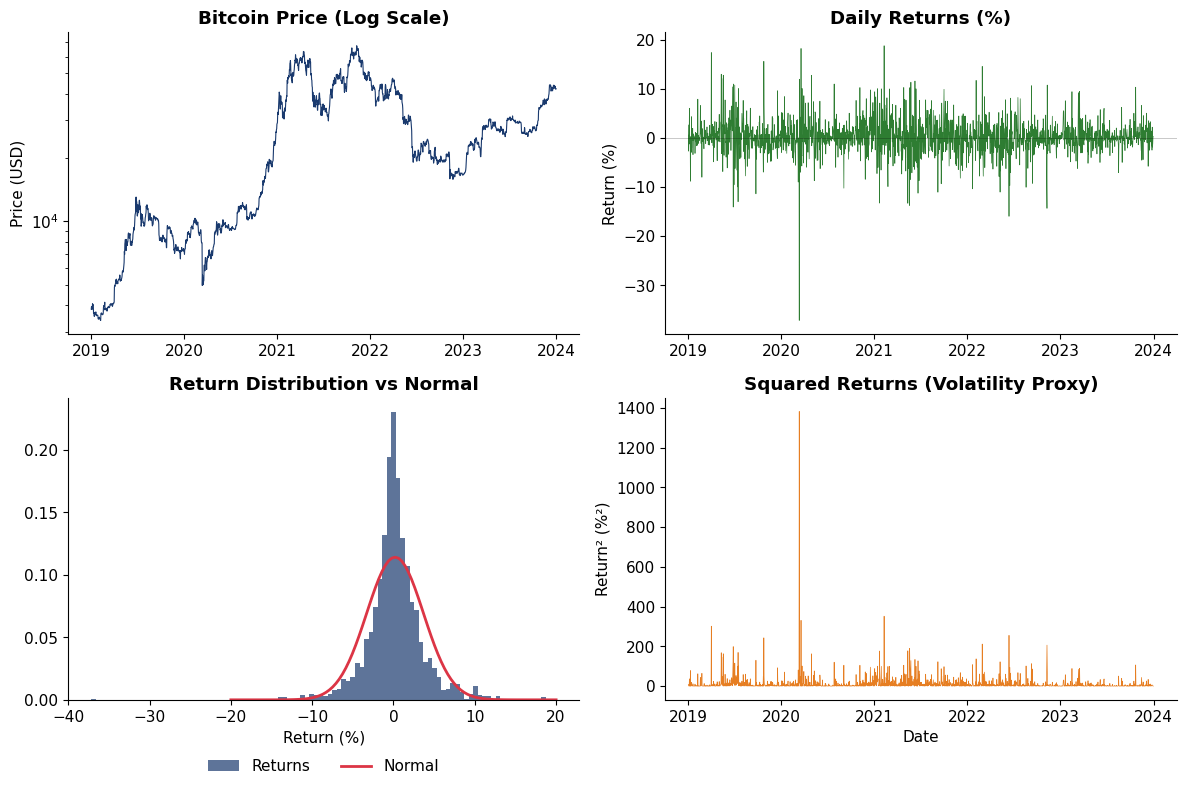


Key Observations:
1. Returns show VOLATILITY CLUSTERING (periods of high/low volatility)
2. Distribution has FAT TAILS (more extreme events than normal)
3. Squared returns show strong persistence -> GARCH is appropriate


In [5]:
# Visualize the data
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Price series
axes[0, 0].plot(btc['ds'], btc['price'], color=COLORS['blue'], linewidth=0.8)
axes[0, 0].set_title('Bitcoin Price (Log Scale)', fontweight='bold')
axes[0, 0].set_ylabel('Price (USD)')
axes[0, 0].set_yscale('log')

# Returns
axes[0, 1].plot(btc['ds'], btc['returns'], color=COLORS['green'], linewidth=0.5)
axes[0, 1].axhline(y=0, color='black', linewidth=0.5, alpha=0.3)
axes[0, 1].set_title('Daily Returns (%)', fontweight='bold')
axes[0, 1].set_ylabel('Return (%)')

# Returns histogram
axes[1, 0].hist(btc['returns'].dropna(), bins=100, color=COLORS['blue'], 
                alpha=0.7, density=True, label='Returns')
# Normal distribution overlay
x = np.linspace(-20, 20, 100)
from scipy.stats import norm
axes[1, 0].plot(x, norm.pdf(x, btc['returns'].mean(), btc['returns'].std()),
                color=COLORS['red'], linewidth=2, label='Normal')
axes[1, 0].set_title('Return Distribution vs Normal', fontweight='bold')
axes[1, 0].set_xlabel('Return (%)')
axes[1, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Squared returns (proxy for volatility)
axes[1, 1].plot(btc['ds'], btc['returns']**2, color=COLORS['orange'], linewidth=0.5)
axes[1, 1].set_title('Squared Returns (Volatility Proxy)', fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Return² (%²)')

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("1. Returns show VOLATILITY CLUSTERING (periods of high/low volatility)")
print("2. Distribution has FAT TAILS (more extreme events than normal)")
print("3. Squared returns show strong persistence -> GARCH is appropriate")

In [6]:
# Step 1: Stationarity Testing
print("STEP 1: STATIONARITY TESTING")
print("="*60)

# Test prices (expect non-stationary)
test_stationarity(btc['price'], 'Bitcoin Prices')

# Test returns (expect stationary)
returns = btc['returns'].dropna()
test_stationarity(returns, 'Bitcoin Returns')

print("\n" + "="*60)
print("CONCLUSION: Use RETURNS (not prices) for modeling")
print("="*60)

STEP 1: STATIONARITY TESTING

Stationarity Tests for Bitcoin Prices
--------------------------------------------------
ADF Test:
  Statistic: -1.5718
  p-value: 0.497721
  Conclusion: NON-STATIONARY

KPSS Test:
  Statistic: 2.5380
  p-value: 0.0100
  Conclusion: NON-STATIONARY

Overall: NON-STATIONARY or INCONCLUSIVE

Stationarity Tests for Bitcoin Returns
--------------------------------------------------
ADF Test:
  Statistic: -20.3152
  p-value: 0.000000
  Conclusion: STATIONARY

KPSS Test:
  Statistic: 0.2561
  p-value: 0.1000
  Conclusion: STATIONARY

Overall: STATIONARY

CONCLUSION: Use RETURNS (not prices) for modeling


/var/folders/pk/sxdc5n5x6mb322grbvxz_nm40000gp/T/ipykernel_17630/2410221013.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c', nlags='auto')
/var/folders/pk/sxdc5n5x6mb322grbvxz_nm40000gp/T/ipykernel_17630/2410221013.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c', nlags='auto')


In [7]:
# Step 2: Train/Validation/Test Split
print("\nSTEP 2: DATA SPLITTING")
print("="*60)
print("\nFor time series, we ALWAYS preserve temporal order!")
print("Never shuffle - the future cannot predict the past.\n")

# Prepare returns data
btc_returns = btc[['ds', 'returns']].dropna().reset_index(drop=True)

# Split: 70% train, 15% validation, 15% test
train_btc, val_btc, test_btc = time_series_split(btc_returns, 0.70, 0.15, 0.15)

print(f"\nDate Ranges:")
print(f"  Training:   {train_btc['ds'].min().date()} to {train_btc['ds'].max().date()}")
print(f"  Validation: {val_btc['ds'].min().date()} to {val_btc['ds'].max().date()}")
print(f"  Test:       {test_btc['ds'].min().date()} to {test_btc['ds'].max().date()}")


STEP 2: DATA SPLITTING

For time series, we ALWAYS preserve temporal order!
Never shuffle - the future cannot predict the past.

Data Split (Total: 1825 observations):
  Training:   1277 (70.0%)
  Validation:  274 (15.0%)
  Test:        274 (15.0%)

Date Ranges:
  Training:   2019-01-02 to 2022-07-01
  Validation: 2022-07-02 to 2023-04-01
  Test:       2023-04-02 to 2023-12-31


In [8]:
# Step 3: Model Selection on Validation Set
print("\nSTEP 3: MODEL SELECTION (using Validation Set)")
print("="*60)

if HAS_ARCH:
    # Combine train+val for model comparison, but evaluate on val only
    train_returns = train_btc['returns'].values
    val_returns = val_btc['returns'].values
    
    # Models to compare
    models_to_test = {
        'GARCH(1,1)': {'vol': 'Garch', 'p': 1, 'q': 1},
        'GARCH(2,1)': {'vol': 'Garch', 'p': 2, 'q': 1},
        'GJR-GARCH(1,1)': {'vol': 'Garch', 'p': 1, 'o': 1, 'q': 1},
        'EGARCH(1,1)': {'vol': 'EGARCH', 'p': 1, 'q': 1}
    }
    
    results_comparison = {}
    
    print("\nComparing GARCH variants on VALIDATION set:")
    print("-" * 60)
    
    for name, params in models_to_test.items():
        try:
            # Fit on training data
            model = arch_model(train_returns, mean='AR', lags=1, **params)
            res = model.fit(disp='off', show_warning=False)
            
            # Forecast on validation period
            forecast = res.forecast(horizon=len(val_returns), reindex=False)
            vol_forecast = np.sqrt(forecast.variance.values[-1, :])
            
            # Calculate realized volatility (|returns| as proxy)
            realized_vol = np.abs(val_returns)
            
            # Metrics: MAE of volatility forecast
            mae = np.mean(np.abs(realized_vol - vol_forecast))
            
            results_comparison[name] = {
                'AIC': res.aic,
                'BIC': res.bic,
                'Val_MAE': mae,
                'model': res
            }
            
            print(f"{name:20s} AIC: {res.aic:10.2f}  BIC: {res.bic:10.2f}  Val MAE: {mae:.4f}")
        except Exception as e:
            print(f"{name:20s} Failed: {e}")
    
    # Select best model based on validation MAE
    best_model_name = min(results_comparison, key=lambda x: results_comparison[x]['Val_MAE'])
    print(f"\n>>> BEST MODEL (lowest validation MAE): {best_model_name}")
else:
    print("ARCH package not available")


STEP 3: MODEL SELECTION (using Validation Set)

Comparing GARCH variants on VALIDATION set:
------------------------------------------------------------
GARCH(1,1)           AIC:    6994.84  BIC:    7020.59  Val MAE: 2.6377
GARCH(2,1)           AIC:    6993.72  BIC:    7024.63  Val MAE: 2.6397
GJR-GARCH(1,1)       AIC:    6983.72  BIC:    7014.63  Val MAE: 2.6692
EGARCH(1,1)          Failed: Analytic forecasts not available for horizon > 1

>>> BEST MODEL (lowest validation MAE): GARCH(1,1)


In [9]:
# Step 4: Final Model - Refit on Train+Val, Evaluate on Test
print("\nSTEP 4: FINAL EVALUATION (Test Set)")
print("="*60)

if HAS_ARCH:
    # Combine training and validation for final model
    trainval_returns = np.concatenate([train_returns, val_returns])
    test_returns = test_btc['returns'].values
    
    print(f"\nRefitting {best_model_name} on Training+Validation data")
    print(f"  Training+Validation: {len(trainval_returns)} observations")
    print(f"  Test: {len(test_returns)} observations (HELD OUT until now!)\n")
    
    # Fit final model
    best_params = models_to_test[best_model_name]
    final_model = arch_model(trainval_returns, mean='AR', lags=1, **best_params)
    final_results = final_model.fit(disp='off')
    
    # Forecast on test set
    final_forecast = final_results.forecast(horizon=len(test_returns), reindex=False)
    test_vol_forecast = np.sqrt(final_forecast.variance.values[-1, :])
    
    # Calculate test metrics
    test_realized_vol = np.abs(test_returns)
    test_mae = np.mean(np.abs(test_realized_vol - test_vol_forecast))
    test_rmse = np.sqrt(np.mean((test_realized_vol - test_vol_forecast)**2))
    
    print(f"TEST SET RESULTS (Unbiased Final Evaluation):")
    print(f"  Volatility MAE:  {test_mae:.4f}")
    print(f"  Volatility RMSE: {test_rmse:.4f}")
    
    # Model summary
    print(f"\n{best_model_name} Model Parameters:")
    print(final_results.summary().tables[1])


STEP 4: FINAL EVALUATION (Test Set)

Refitting GARCH(1,1) on Training+Validation data
  Training+Validation: 1551 observations
  Test: 274 observations (HELD OUT until now!)

TEST SET RESULTS (Unbiased Final Evaluation):
  Volatility MAE:  2.6362
  Volatility RMSE: 2.8224

GARCH(1,1) Model Parameters:
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.2396  8.838e-02      2.711  6.713e-03    [6.636e-02,  0.413]
y[1]          -0.0274  3.563e-02     -0.768      0.443 [-9.720e-02,4.249e-02]


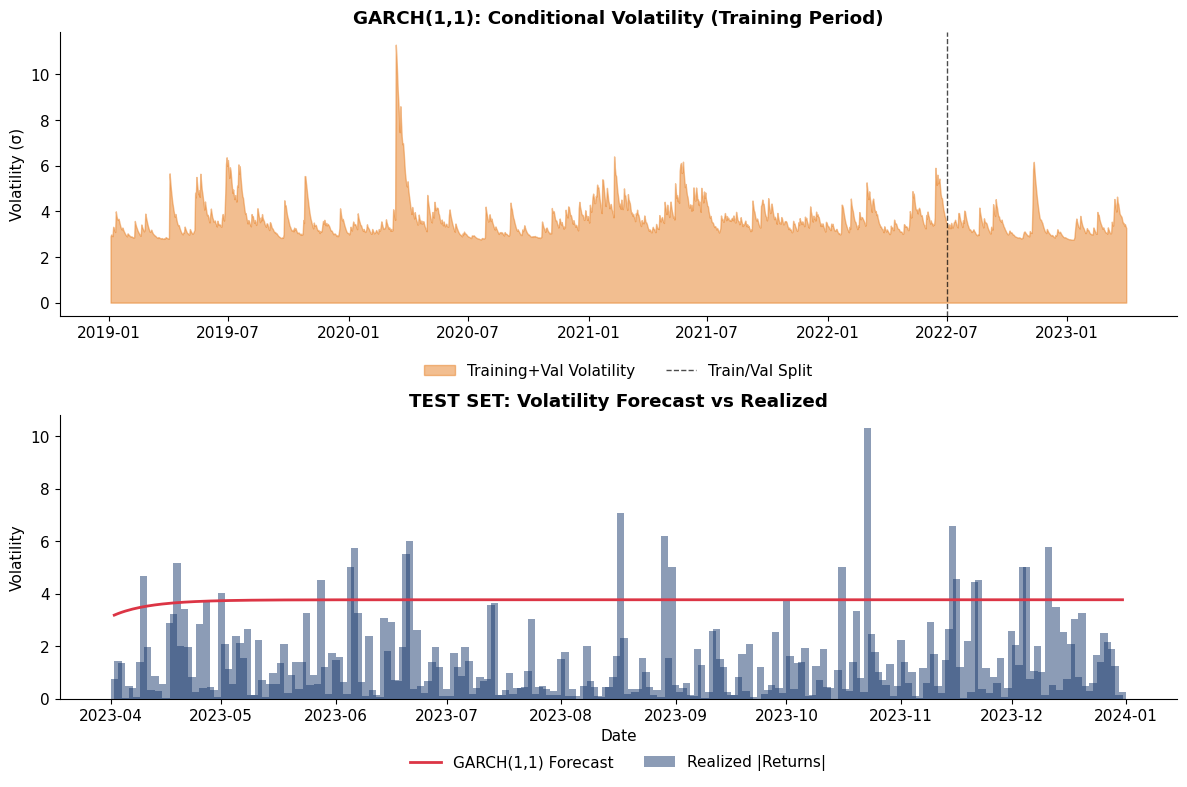


CASE STUDY 1 SUMMARY: Bitcoin Volatility
Best Model: GARCH(1,1)
Test MAE: 2.6362

Key Insight: Volatility is predictable even when returns are not!


In [10]:
# Visualize final results
if HAS_ARCH:
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot 1: Conditional volatility on full training period
    cond_vol = final_results.conditional_volatility
    train_val_dates = pd.concat([train_btc['ds'], val_btc['ds']])
    
    axes[0].fill_between(train_val_dates, 0, cond_vol, 
                         color=COLORS['orange'], alpha=0.5, label='Training+Val Volatility')
    axes[0].axvline(x=train_btc['ds'].iloc[-1], color='black', linestyle='--', 
                    linewidth=1, alpha=0.7, label='Train/Val Split')
    axes[0].set_title(f'{best_model_name}: Conditional Volatility (Training Period)', fontweight='bold')
    axes[0].set_ylabel('Volatility (σ)')
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)
    
    # Plot 2: Test set - Forecast vs Realized
    test_dates = test_btc['ds']
    axes[1].bar(test_dates, test_realized_vol, color=COLORS['blue'], 
                alpha=0.5, width=2, label='Realized |Returns|')
    axes[1].plot(test_dates, test_vol_forecast, color=COLORS['red'], 
                 linewidth=2, label=f'{best_model_name} Forecast')
    axes[1].set_title('TEST SET: Volatility Forecast vs Realized', fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Volatility')
    axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.35)
    plt.show()
    
    print("\n" + "="*60)
    print("CASE STUDY 1 SUMMARY: Bitcoin Volatility")
    print("="*60)
    print(f"Best Model: {best_model_name}")
    print(f"Test MAE: {test_mae:.4f}")
    print("\nKey Insight: Volatility is predictable even when returns are not!")

---
# Case Study 2: Sunspot Cycle Analysis

## Objective
Model the 11-year solar cycle using Fourier terms.

## Challenge
- Seasonal period of 11 years is too long for standard SARIMA
- Solution: Use Fourier terms as exogenous regressors

## Methodology
1. **Training (70%)**: Fit ARIMA with Fourier terms
2. **Validation (15%)**: Select optimal number of Fourier harmonics (K=1,2,3,4)
3. **Test (15%)**: Final forecast evaluation

In [11]:
# Load Sunspot data
sunspots = get_sunspot_data()

print("\n" + "="*60)
print("SUNSPOT DATA OVERVIEW")
print("="*60)
print(f"Period: {sunspots['ds'].min().year} to {sunspots['ds'].max().year}")
print(f"Observations: {len(sunspots)} years")
print(f"\nStatistics:")
print(f"  Mean: {sunspots['y'].mean():.1f}")
print(f"  Std:  {sunspots['y'].std():.1f}")
print(f"  Min:  {sunspots['y'].min():.0f}")
print(f"  Max:  {sunspots['y'].max():.0f}")
print(f"\nKnown Feature: ~11-year Schwabe solar cycle")

Sunspots: Loaded 109 years of REAL data from statsmodels

SUNSPOT DATA OVERVIEW
Period: 1900 to 2008
Observations: 109 years

Statistics:
  Mean: 60.1
  Std:  47.7
  Min:  1
  Max:  190

Known Feature: ~11-year Schwabe solar cycle


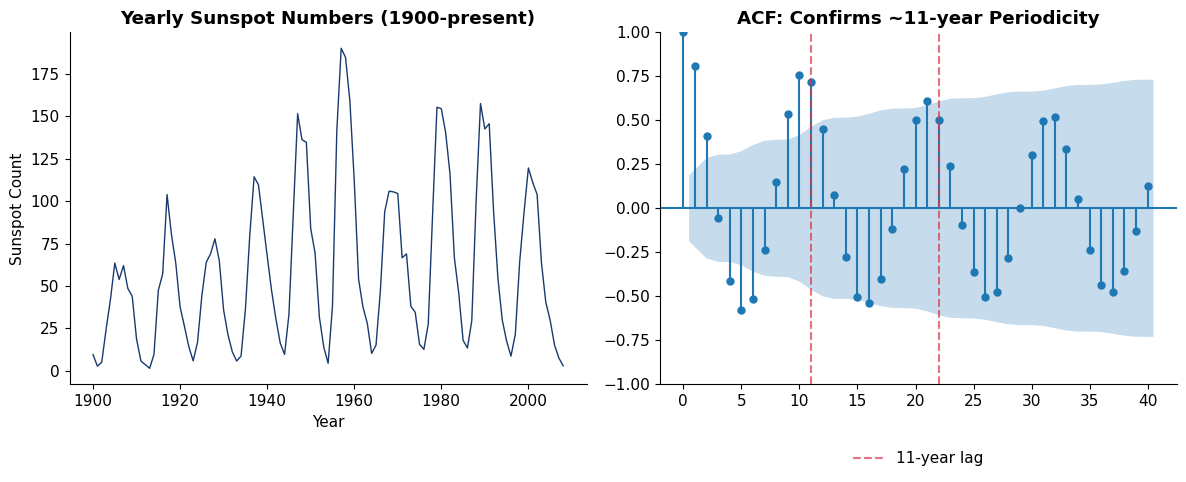

ACF shows clear peaks at lags 11 and 22, confirming the solar cycle.


In [12]:
# Visualize and confirm the cycle
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Time series
axes[0].plot(sunspots['ds'], sunspots['y'], color=COLORS['blue'], linewidth=1)
axes[0].set_title('Yearly Sunspot Numbers (1900-present)', fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Sunspot Count')

# ACF to confirm periodicity
plot_acf(sunspots['y'], ax=axes[1], lags=40, alpha=0.05)
axes[1].axvline(x=11, color=COLORS['red'], linestyle='--', alpha=0.7, label='11-year lag')
axes[1].axvline(x=22, color=COLORS['red'], linestyle='--', alpha=0.7)
axes[1].set_title('ACF: Confirms ~11-year Periodicity', fontweight='bold')
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)

plt.tight_layout()
plt.show()

print("ACF shows clear peaks at lags 11 and 22, confirming the solar cycle.")

In [13]:
# Step 1: Train/Validation/Test Split
print("\nSTEP 1: DATA SPLITTING")
print("="*60)

train_sun, val_sun, test_sun = time_series_split(sunspots, 0.70, 0.15, 0.15)

print(f"\nDate Ranges:")
print(f"  Training:   {train_sun['ds'].min().year} to {train_sun['ds'].max().year}")
print(f"  Validation: {val_sun['ds'].min().year} to {val_sun['ds'].max().year}")
print(f"  Test:       {test_sun['ds'].min().year} to {test_sun['ds'].max().year}")


STEP 1: DATA SPLITTING
Data Split (Total: 109 observations):
  Training:     76 (69.7%)
  Validation:   16 (14.7%)
  Test:         17 (15.6%)

Date Ranges:
  Training:   1900 to 1975
  Validation: 1976 to 1991
  Test:       1992 to 2008


In [14]:
# Step 2: Add Fourier terms and select K
print("\nSTEP 2: MODEL SELECTION - Finding Optimal Number of Fourier Harmonics")
print("="*60)

def add_fourier_terms(df, period, K, start_idx=0):
    """Add K Fourier pairs (sin/cos) for given period"""
    result = df.copy()
    t = np.arange(start_idx, start_idx + len(df))
    for k in range(1, K + 1):
        result[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        result[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return result

# Test K = 1, 2, 3, 4 Fourier pairs
results_K = {}

print("\nComparing Fourier harmonics K=1,2,3,4 on VALIDATION set:")
print("-" * 60)

for K in [1, 2, 3, 4]:
    # Add Fourier terms
    train_fourier = add_fourier_terms(train_sun, period=11, K=K, start_idx=0)
    val_fourier = add_fourier_terms(val_sun, period=11, K=K, start_idx=len(train_sun))
    
    exog_cols = [f'sin_{k}' for k in range(1, K+1)] + [f'cos_{k}' for k in range(1, K+1)]
    
    # Fit ARIMA(2,0,1) with Fourier regressors
    try:
        model = SARIMAX(train_fourier['y'], 
                       exog=train_fourier[exog_cols],
                       order=(2, 0, 1),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        res = model.fit(disp=False)
        
        # Forecast on validation
        forecast = res.get_forecast(steps=len(val_fourier), exog=val_fourier[exog_cols])
        val_pred = forecast.predicted_mean.values
        
        # Metrics
        rmse = np.sqrt(mean_squared_error(val_fourier['y'], val_pred))
        mae = mean_absolute_error(val_fourier['y'], val_pred)
        
        results_K[K] = {'AIC': res.aic, 'BIC': res.bic, 'RMSE': rmse, 'MAE': mae, 'model': res}
        print(f"K={K}: AIC={res.aic:8.2f}  BIC={res.bic:8.2f}  Val RMSE={rmse:6.2f}  Val MAE={mae:6.2f}")
    except Exception as e:
        print(f"K={K}: Failed - {e}")

# Select best K
best_K = min(results_K, key=lambda x: results_K[x]['RMSE'])
print(f"\n>>> BEST: K={best_K} Fourier harmonics (lowest validation RMSE)")


STEP 2: MODEL SELECTION - Finding Optimal Number of Fourier Harmonics

Comparing Fourier harmonics K=1,2,3,4 on VALIDATION set:
------------------------------------------------------------
K=1: AIC=  665.92  BIC=  679.75  Val RMSE= 87.15  Val MAE= 73.77
K=2: AIC=  668.00  BIC=  686.43  Val RMSE= 86.92  Val MAE= 74.04


K=3: AIC=  671.82  BIC=  694.86  Val RMSE= 86.81  Val MAE= 73.99


K=4: AIC=  674.53  BIC=  702.18  Val RMSE= 87.93  Val MAE= 75.52

>>> BEST: K=3 Fourier harmonics (lowest validation RMSE)


In [15]:
# Step 3: Final Model - Refit on Train+Val, Evaluate on Test
print("\nSTEP 3: FINAL EVALUATION (Test Set)")
print("="*60)

# Combine training and validation
trainval_sun = pd.concat([train_sun, val_sun]).reset_index(drop=True)

# Add Fourier terms
trainval_fourier = add_fourier_terms(trainval_sun, period=11, K=best_K, start_idx=0)
test_fourier = add_fourier_terms(test_sun, period=11, K=best_K, start_idx=len(trainval_sun))

exog_cols = [f'sin_{k}' for k in range(1, best_K+1)] + [f'cos_{k}' for k in range(1, best_K+1)]

print(f"\nRefitting ARIMA(2,0,1) + {best_K} Fourier harmonics")
print(f"  Training+Validation: {len(trainval_fourier)} years")
print(f"  Test: {len(test_fourier)} years (HELD OUT until now!)\n")

# Fit final model
final_sun_model = SARIMAX(trainval_fourier['y'],
                          exog=trainval_fourier[exog_cols],
                          order=(2, 0, 1),
                          enforce_stationarity=False,
                          enforce_invertibility=False)
final_sun_results = final_sun_model.fit(disp=False)

# Forecast on test
test_forecast = final_sun_results.get_forecast(steps=len(test_fourier), exog=test_fourier[exog_cols])
test_pred = test_forecast.predicted_mean.values
test_ci = test_forecast.conf_int()

# Metrics
test_metrics = calc_metrics(test_fourier['y'], test_pred, "TEST SET")

print(f"\nModel Summary:")
print(final_sun_results.summary().tables[1])


STEP 3: FINAL EVALUATION (Test Set)

Refitting ARIMA(2,0,1) + 3 Fourier harmonics
  Training+Validation: 92 years
  Test: 17 years (HELD OUT until now!)




TEST SET Metrics:
  RMSE: 48.5085
  MAE:  39.3059
  MAPE: 165.47%

Model Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1         34.7108      9.556      3.632      0.000      15.982      53.439
sin_2          2.6457      4.161      0.636      0.525      -5.511      10.802
sin_3          1.9737      2.080      0.949      0.343      -2.104       6.051
cos_1        -29.2066     12.310     -2.373      0.018     -53.333      -5.080
cos_2         -4.4436      4.200     -1.058      0.290     -12.675       3.788
cos_3         -0.1673      2.129     -0.079      0.937      -4.340       4.006
ar.L1          1.3405      0.225      5.959      0.000       0.900       1.781
ar.L2         -0.4090      0.227     -1.801      0.072      -0.854       0.036
ma.L1          0.0270      0.265      0.102      0.919      -0.493       0.547
sigma2       429.2287     71.020      6.044     

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


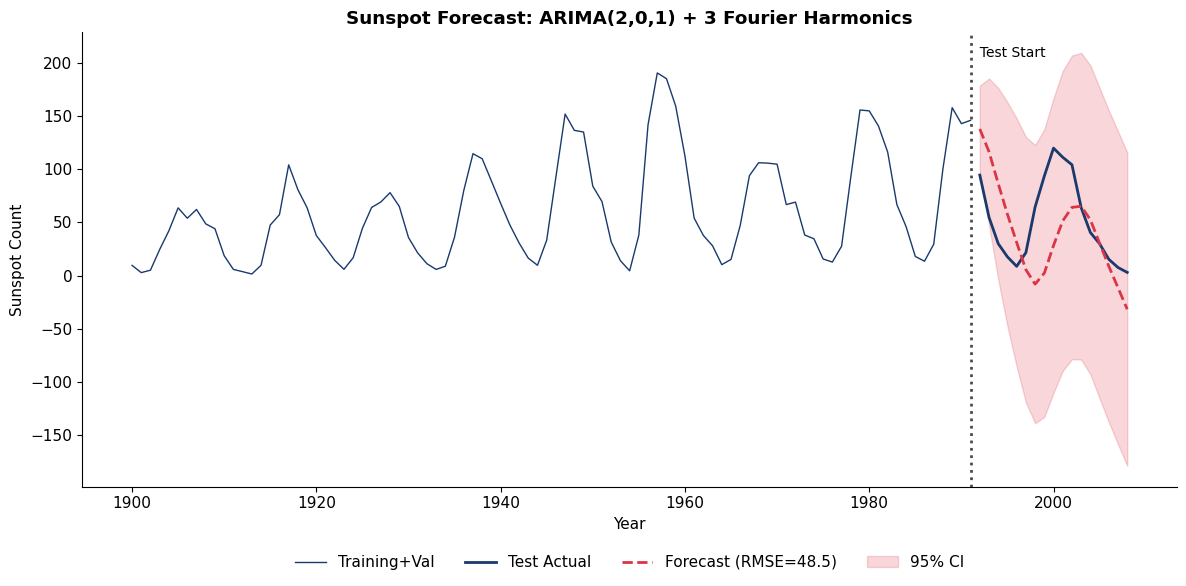


CASE STUDY 2 SUMMARY: Sunspot Cycles
Best Model: ARIMA(2,0,1) + 3 Fourier harmonics
Test RMSE: 48.51
Test MAPE: 165.47%

Key Insight: Fourier terms capture long seasonal patterns effectively!


In [16]:
# Visualize final results
fig, ax = plt.subplots(figsize=(12, 6))

# Training data
ax.plot(trainval_fourier['ds'], trainval_fourier['y'], 
        color=COLORS['blue'], linewidth=1, label='Training+Val')

# Test actual
ax.plot(test_fourier['ds'], test_fourier['y'], 
        color=COLORS['blue'], linewidth=2, label='Test Actual')

# Test forecast
ax.plot(test_fourier['ds'], test_pred, 
        color=COLORS['red'], linewidth=2, linestyle='--', 
        label=f'Forecast (RMSE={test_metrics["rmse"]:.1f})')

# Confidence interval
ax.fill_between(test_fourier['ds'], test_ci.iloc[:, 0], test_ci.iloc[:, 1],
                color=COLORS['red'], alpha=0.2, label='95% CI')

# Mark train/test split
ax.axvline(x=trainval_fourier['ds'].iloc[-1], color='black', 
           linestyle=':', linewidth=2, alpha=0.7)
ax.text(trainval_fourier['ds'].iloc[-1], ax.get_ylim()[1]*0.9, 
        '  Test Start', fontsize=10)

ax.set_title(f'Sunspot Forecast: ARIMA(2,0,1) + {best_K} Fourier Harmonics', fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Sunspot Count')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CASE STUDY 2 SUMMARY: Sunspot Cycles")
print("="*60)
print(f"Best Model: ARIMA(2,0,1) + {best_K} Fourier harmonics")
print(f"Test RMSE: {test_metrics['rmse']:.2f}")
print(f"Test MAPE: {test_metrics['mape']:.2f}%")
print("\nKey Insight: Fourier terms capture long seasonal patterns effectively!")

---
# Case Study 3: US Unemployment with Structural Break

## Objective
Handle the COVID-19 structural break using Prophet's changepoint detection.

## Challenge
- April 2020: Unemployment jumped from 3.5% to 14.7% (largest single-month increase ever)
- Traditional ARIMA struggles with such extreme outliers

## Methodology
1. **Training (70%)**: Fit Prophet with changepoint detection
2. **Validation (15%)**: Tune changepoint_prior_scale
3. **Test (15%)**: Final evaluation

In [17]:
# Load Unemployment data
unemp = get_unemployment_data()

print("\n" + "="*60)
print("US UNEMPLOYMENT DATA OVERVIEW")
print("="*60)
print(f"Period: {unemp['ds'].min().strftime('%Y-%m')} to {unemp['ds'].max().strftime('%Y-%m')}")
print(f"Observations: {len(unemp)} months")
print(f"\nKey Statistics:")
print(f"  Pre-COVID Min (Feb 2020): {unemp[unemp['ds'] < '2020-03-01']['y'].min():.1f}%")
print(f"  COVID Peak (Apr 2020):    {unemp['y'].max():.1f}%")
print(f"  Latest:                   {unemp['y'].iloc[-1]:.1f}%")
print(f"\nStructural Break: March-April 2020")

US Unemployment: Loaded 168 months of REAL data from FRED

US UNEMPLOYMENT DATA OVERVIEW
Period: 2010-01 to 2023-12
Observations: 168 months

Key Statistics:
  Pre-COVID Min (Feb 2020): 3.5%
  COVID Peak (Apr 2020):    14.8%
  Latest:                   3.8%

Structural Break: March-April 2020


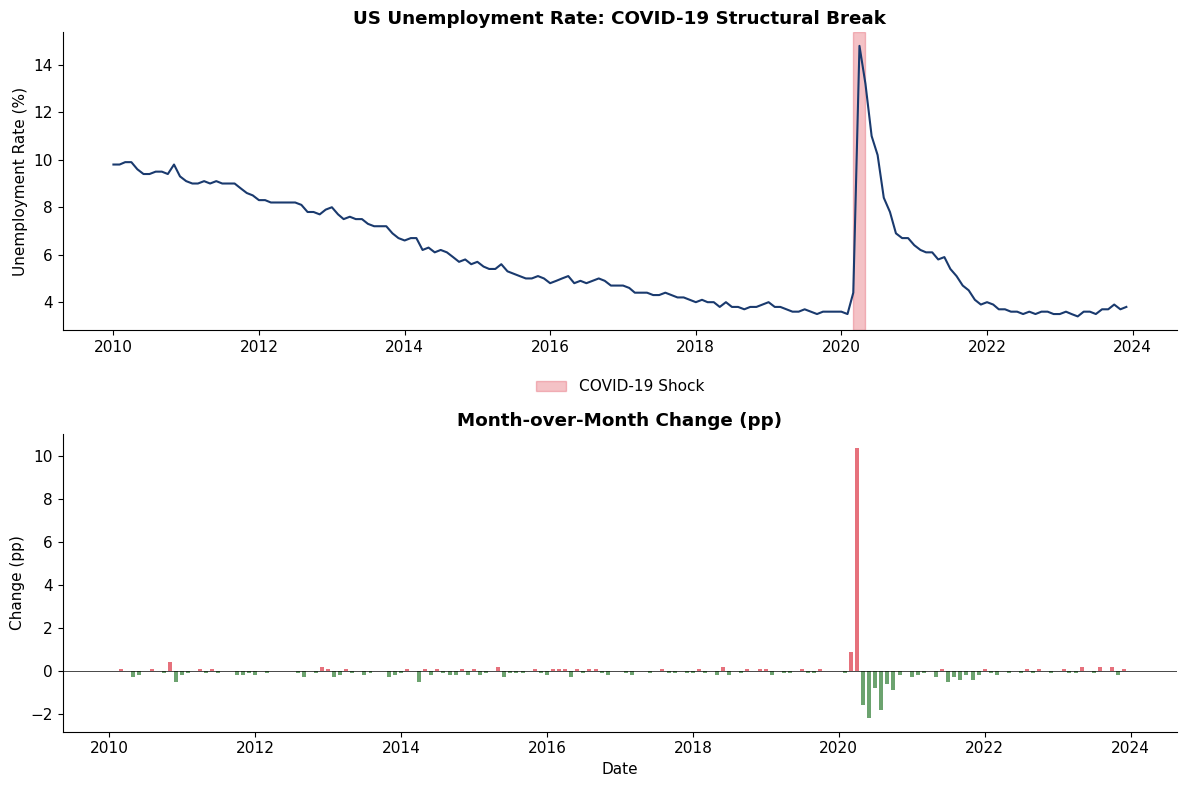

April 2020: +10.3 percentage points - largest monthly increase in history!


In [18]:
# Visualize the structural break
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Main plot
axes[0].plot(unemp['ds'], unemp['y'], color=COLORS['blue'], linewidth=1.5)
axes[0].axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-05-01'),
                alpha=0.3, color=COLORS['red'], label='COVID-19 Shock')
axes[0].set_title('US Unemployment Rate: COVID-19 Structural Break', fontweight='bold')
axes[0].set_ylabel('Unemployment Rate (%)')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=1)

# Month-over-month change
unemp_change = unemp['y'].diff()
colors_bar = [COLORS['green'] if x < 0 else COLORS['red'] for x in unemp_change]
axes[1].bar(unemp['ds'], unemp_change, color=colors_bar, width=20, alpha=0.7)
axes[1].axhline(y=0, color='black', linewidth=0.5)
axes[1].set_title('Month-over-Month Change (pp)', fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Change (pp)')

plt.tight_layout()
plt.subplots_adjust(hspace=0.35)
plt.show()

print("April 2020: +10.3 percentage points - largest monthly increase in history!")

In [19]:
# Step 1: Train/Validation/Test Split
print("\nSTEP 1: DATA SPLITTING")
print("="*60)

train_unemp, val_unemp, test_unemp = time_series_split(unemp, 0.70, 0.15, 0.15)

print(f"\nDate Ranges:")
print(f"  Training:   {train_unemp['ds'].min().strftime('%Y-%m')} to {train_unemp['ds'].max().strftime('%Y-%m')}")
print(f"  Validation: {val_unemp['ds'].min().strftime('%Y-%m')} to {val_unemp['ds'].max().strftime('%Y-%m')}")
print(f"  Test:       {test_unemp['ds'].min().strftime('%Y-%m')} to {test_unemp['ds'].max().strftime('%Y-%m')}")


STEP 1: DATA SPLITTING
Data Split (Total: 168 observations):
  Training:    117 (69.6%)
  Validation:   25 (14.9%)
  Test:         26 (15.5%)

Date Ranges:
  Training:   2010-01 to 2019-09
  Validation: 2019-10 to 2021-10
  Test:       2021-11 to 2023-12


In [20]:
# Step 2: Model Selection - Tune changepoint_prior_scale
print("\nSTEP 2: MODEL SELECTION - Tuning Prophet Hyperparameters")
print("="*60)

if HAS_PROPHET:
    # Test different changepoint_prior_scale values
    scales_to_test = [0.01, 0.05, 0.1, 0.3, 0.5]
    results_prophet = {}
    
    print("\nComparing changepoint_prior_scale on VALIDATION set:")
    print("-" * 60)
    print("(Higher scale = more flexible trend, can overfit)")
    print("(Lower scale = smoother trend, may underfit)\n")
    
    for scale in scales_to_test:
        try:
            # Fit on training data
            model = Prophet(
                changepoint_prior_scale=scale,
                yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False
            )
            model.fit(train_unemp, suppress_logging=True)
            
            # Predict on validation
            future_val = model.make_future_dataframe(periods=len(val_unemp), freq='MS')
            forecast_val = model.predict(future_val)
            val_pred = forecast_val['yhat'].iloc[-len(val_unemp):].values
            
            # Metrics
            rmse = np.sqrt(mean_squared_error(val_unemp['y'], val_pred))
            mae = mean_absolute_error(val_unemp['y'], val_pred)
            
            results_prophet[scale] = {'RMSE': rmse, 'MAE': mae, 'model': model}
            print(f"scale={scale:4.2f}: Val RMSE={rmse:6.3f}  Val MAE={mae:6.3f}")
        except Exception as e:
            print(f"scale={scale:4.2f}: Failed - {e}")
    
    # Select best scale
    best_scale = min(results_prophet, key=lambda x: results_prophet[x]['RMSE'])
    print(f"\n>>> BEST: changepoint_prior_scale={best_scale} (lowest validation RMSE)")
else:
    print("Prophet not available")


STEP 2: MODEL SELECTION - Tuning Prophet Hyperparameters
Prophet not available


In [21]:
# Step 3: Final Model - Refit on Train+Val, Evaluate on Test
print("\nSTEP 3: FINAL EVALUATION (Test Set)")
print("="*60)

if HAS_PROPHET:
    # Combine training and validation
    trainval_unemp = pd.concat([train_unemp, val_unemp]).reset_index(drop=True)
    
    print(f"\nRefitting Prophet with changepoint_prior_scale={best_scale}")
    print(f"  Training+Validation: {len(trainval_unemp)} months")
    print(f"  Test: {len(test_unemp)} months (HELD OUT until now!)\n")
    
    # Fit final model
    final_prophet = Prophet(
        changepoint_prior_scale=best_scale,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    final_prophet.fit(trainval_unemp, suppress_logging=True)
    
    # Predict on test
    future_test = final_prophet.make_future_dataframe(periods=len(test_unemp), freq='MS')
    forecast_test = final_prophet.predict(future_test)
    test_pred_prophet = forecast_test['yhat'].iloc[-len(test_unemp):].values
    test_lower = forecast_test['yhat_lower'].iloc[-len(test_unemp):].values
    test_upper = forecast_test['yhat_upper'].iloc[-len(test_unemp):].values
    
    # Metrics
    test_prophet_metrics = calc_metrics(test_unemp['y'], test_pred_prophet, "TEST SET")


STEP 3: FINAL EVALUATION (Test Set)


In [22]:
# Visualize final results
if HAS_PROPHET:
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Full forecast
    axes[0].plot(unemp['ds'], unemp['y'], color=COLORS['blue'], 
                 linewidth=1.5, label='Actual')
    axes[0].plot(forecast_test['ds'], forecast_test['yhat'], 
                 color=COLORS['orange'], linewidth=1.5, linestyle='--', label='Prophet Forecast')
    axes[0].fill_between(forecast_test['ds'], forecast_test['yhat_lower'], 
                        forecast_test['yhat_upper'], color=COLORS['orange'], alpha=0.2)
    axes[0].axvline(x=trainval_unemp['ds'].iloc[-1], color='black', 
                    linestyle=':', linewidth=2, alpha=0.7)
    
    # Mark detected changepoints
    for cp in final_prophet.changepoints:
        axes[0].axvline(x=cp, color=COLORS['red'], linestyle='--', alpha=0.3, linewidth=1)
    
    axes[0].set_title('Prophet Model with Changepoint Detection', fontweight='bold')
    axes[0].set_ylabel('Unemployment Rate (%)')
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)
    
    # Test period zoom
    axes[1].plot(test_unemp['ds'], test_unemp['y'], 
                 color=COLORS['blue'], linewidth=2, marker='o', label='Test Actual')
    axes[1].plot(test_unemp['ds'], test_pred_prophet, 
                 color=COLORS['red'], linewidth=2, marker='s', linestyle='--', 
                 label=f'Forecast (RMSE={test_prophet_metrics["rmse"]:.3f})')
    axes[1].fill_between(test_unemp['ds'], test_lower, test_upper,
                        color=COLORS['red'], alpha=0.2, label='95% CI')
    axes[1].set_title('TEST SET: Forecast vs Actual', fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Unemployment Rate (%)')
    axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.35)
    plt.show()
    
    print("\n" + "="*60)
    print("CASE STUDY 3 SUMMARY: Unemployment with Structural Break")
    print("="*60)
    print(f"Best Model: Prophet (changepoint_prior_scale={best_scale})")
    print(f"Test RMSE: {test_prophet_metrics['rmse']:.4f}")
    print(f"Test MAPE: {test_prophet_metrics['mape']:.2f}%")
    print(f"Changepoints detected: {len(final_prophet.changepoints)}")
    print("\nKey Insight: Prophet adapts to structural breaks via changepoints!")

---
# Case Study 4: Multivariate Analysis (VAR Model)

## Objective
Model the relationships between multiple economic variables using Vector Autoregression (VAR).

## Variables
- **GDP Growth** (quarterly, YoY %)
- **Unemployment Rate** (%)
- **Inflation** (CPI, YoY %)
- **Federal Funds Rate** (%)

## Why VAR?
- Captures **dynamic interdependencies** between multiple time series
- Each variable is regressed on its own lags AND lags of all other variables
- Enables **Granger causality** testing and **impulse response** analysis

## Methodology
1. **Training (70%)**: Fit VAR model
2. **Validation (15%)**: Select optimal lag order
3. **Test (15%)**: Multivariate forecast evaluation

In [23]:
# Load multivariate economic data
econ_data = get_multivariate_economic_data()

print("\n" + "="*60)
print("MULTIVARIATE ECONOMIC DATA OVERVIEW")
print("="*60)
print(f"Period: {econ_data.index.min().strftime('%Y-Q%q')} to {econ_data.index.max().strftime('%Y-Q%q')}")
print(f"Observations: {len(econ_data)} quarters")
print(f"\nVariables:")
for col in econ_data.columns:
    print(f"  {col:15s}: Mean={econ_data[col].mean():6.2f}, Std={econ_data[col].std():5.2f}")

print("\nCorrelation Matrix:")
print(econ_data.corr().round(2))

Could not load economic data: Empty dataframe after merging FRED data
Using backup simulated data...

MULTIVARIATE ECONOMIC DATA OVERVIEW
Period: 2000-Qq to 2023-Qq
Observations: 96 quarters

Variables:
  gdp_growth     : Mean=  2.19, Std= 1.59
  unemployment   : Mean=  4.69, Std= 1.03
  inflation      : Mean=  2.77, Std= 0.51
  fed_rate       : Mean=  3.37, Std= 0.44

Correlation Matrix:
              gdp_growth  unemployment  inflation  fed_rate
gdp_growth          1.00         -0.80       0.09      0.06
unemployment       -0.80          1.00      -0.05     -0.01
inflation           0.09         -0.05       1.00      0.67
fed_rate            0.06         -0.01       0.67      1.00


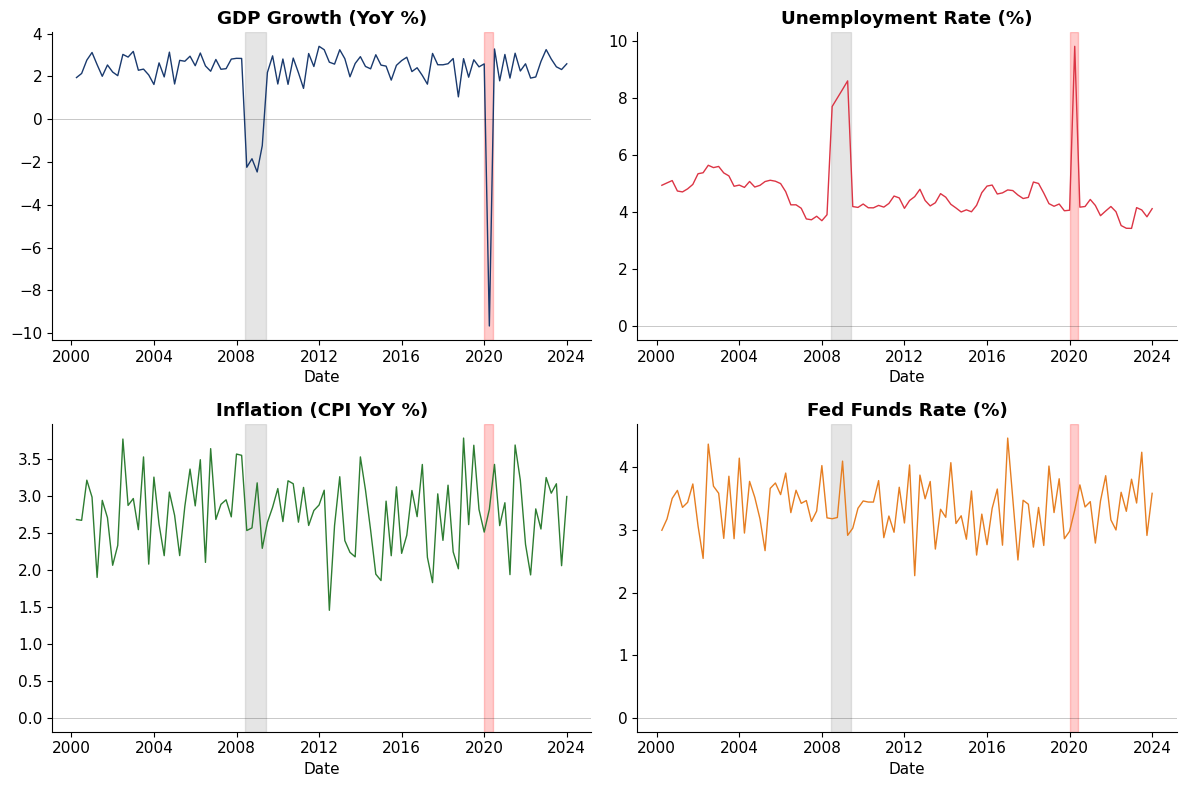

Key Observations:
- GDP and Unemployment are negatively correlated (Okun's Law)
- Fed Rate responds to inflation (Taylor Rule)
- All variables affected by 2008 crisis and COVID


In [24]:
# Visualize all variables
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

variables = ['gdp_growth', 'unemployment', 'inflation', 'fed_rate']
titles = ['GDP Growth (YoY %)', 'Unemployment Rate (%)', 'Inflation (CPI YoY %)', 'Fed Funds Rate (%)']
colors = [COLORS['blue'], COLORS['red'], COLORS['green'], COLORS['orange']]

for ax, var, title, color in zip(axes.flat, variables, titles, colors):
    ax.plot(econ_data.index, econ_data[var], color=color, linewidth=1)
    ax.axhline(y=0, color='black', linewidth=0.5, alpha=0.3)
    ax.axvspan(pd.Timestamp('2008-06-01'), pd.Timestamp('2009-06-01'),
               alpha=0.2, color='gray', label='2008 Crisis')
    ax.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-06-01'),
               alpha=0.2, color='red', label='COVID')
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

print("Key Observations:")
print("- GDP and Unemployment are negatively correlated (Okun's Law)")
print("- Fed Rate responds to inflation (Taylor Rule)")
print("- All variables affected by 2008 crisis and COVID")

In [25]:
# Step 1: Stationarity Testing
print("\nSTEP 1: STATIONARITY TESTING")
print("="*60)
print("VAR requires all variables to be stationary.\n")

for var in econ_data.columns:
    adf_result = adfuller(econ_data[var].dropna(), autolag='AIC')
    status = "STATIONARY" if adf_result[1] < 0.05 else "NON-STATIONARY"
    print(f"{var:15s}: ADF p-value={adf_result[1]:.4f} -> {status}")

print("\nNote: Some variables may need differencing for strict stationarity.")
print("For this example, we proceed with levels (common in macroeconomics).")


STEP 1: STATIONARITY TESTING
VAR requires all variables to be stationary.

gdp_growth     : ADF p-value=0.0000 -> STATIONARY
unemployment   : ADF p-value=0.0000 -> STATIONARY
inflation      : ADF p-value=0.0000 -> STATIONARY


fed_rate       : ADF p-value=0.0000 -> STATIONARY

Note: Some variables may need differencing for strict stationarity.
For this example, we proceed with levels (common in macroeconomics).


In [26]:
# Step 2: Train/Validation/Test Split
print("\nSTEP 2: DATA SPLITTING")
print("="*60)

n = len(econ_data)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

train_econ = econ_data.iloc[:train_end]
val_econ = econ_data.iloc[train_end:val_end]
test_econ = econ_data.iloc[val_end:]

print(f"Data Split (Total: {n} quarters):")
print(f"  Training:   {len(train_econ):3d} quarters ({train_econ.index.min().strftime('%Y-Q%q')} to {train_econ.index.max().strftime('%Y-Q%q')})")
print(f"  Validation: {len(val_econ):3d} quarters ({val_econ.index.min().strftime('%Y-Q%q')} to {val_econ.index.max().strftime('%Y-Q%q')})")
print(f"  Test:       {len(test_econ):3d} quarters ({test_econ.index.min().strftime('%Y-Q%q')} to {test_econ.index.max().strftime('%Y-Q%q')})")


STEP 2: DATA SPLITTING
Data Split (Total: 96 quarters):
  Training:    67 quarters (2000-Qq to 2016-Qq)
  Validation:  14 quarters (2016-Qq to 2020-Qq)
  Test:        15 quarters (2020-Qq to 2023-Qq)


In [27]:
# Step 3: Model Selection - Find optimal lag order
print("\nSTEP 3: MODEL SELECTION - Finding Optimal VAR Lag Order")
print("="*60)

# Fit VAR to find optimal lag using information criteria
var_model = VAR(train_econ)
lag_selection = var_model.select_order(maxlags=8)

print("\nInformation Criteria for Different Lag Orders:")
print(lag_selection.summary())

# Use BIC-selected lag (tends to be more parsimonious)
optimal_lag = lag_selection.bic
print(f"\n>>> Selected lag order (BIC): {optimal_lag}")


STEP 3: MODEL SELECTION - Finding Optimal VAR Lag Order

Information Criteria for Different Lag Orders:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -4.131      -3.990     0.01607      -4.076
1     -4.874*     -4.169*   0.007659*     -4.599*
2      -4.805      -3.537    0.008269      -4.310
3      -4.526      -2.695     0.01114      -3.811
4      -4.348      -1.953     0.01384      -3.413
5      -4.338      -1.380     0.01488      -3.183
6      -4.179     -0.6574     0.01924      -2.804
7      -3.971      0.1138     0.02736      -2.376
8      -3.947      0.7012     0.03450      -2.132
-------------------------------------------------

>>> Selected lag order (BIC): 1


In [28]:
# Validate lag selection on validation set
print("\nValidating lag selection on VALIDATION set:")
print("-" * 60)

results_var = {}

for lag in range(1, 6):
    try:
        # Fit on training
        model = VAR(train_econ)
        fitted = model.fit(lag)
        
        # Forecast validation period
        forecast = fitted.forecast(train_econ.values[-lag:], steps=len(val_econ))
        
        # Calculate RMSE for each variable
        rmse_total = 0
        for i, var in enumerate(econ_data.columns):
            rmse = np.sqrt(mean_squared_error(val_econ[var], forecast[:, i]))
            rmse_total += rmse
        
        results_var[lag] = {'RMSE': rmse_total / len(econ_data.columns), 'model': fitted}
        print(f"Lag={lag}: Avg RMSE={rmse_total/len(econ_data.columns):.4f}")
    except Exception as e:
        print(f"Lag={lag}: Failed - {e}")

best_lag = min(results_var, key=lambda x: results_var[x]['RMSE'])
print(f"\n>>> BEST: Lag={best_lag} (lowest validation RMSE)")


Validating lag selection on VALIDATION set:
------------------------------------------------------------
Lag=1: Avg RMSE=1.4265
Lag=2: Avg RMSE=1.4284
Lag=3: Avg RMSE=1.4428
Lag=4: Avg RMSE=1.4657
Lag=5: Avg RMSE=1.5156

>>> BEST: Lag=1 (lowest validation RMSE)


In [29]:
# Step 4: Final Model - Refit on Train+Val, Evaluate on Test
print("\nSTEP 4: FINAL EVALUATION (Test Set)")
print("="*60)

# Combine training and validation
trainval_econ = pd.concat([train_econ, val_econ])

print(f"\nRefitting VAR({best_lag}) on Training+Validation data")
print(f"  Training+Validation: {len(trainval_econ)} quarters")
print(f"  Test: {len(test_econ)} quarters (HELD OUT until now!)\n")

# Fit final model
final_var = VAR(trainval_econ)
final_var_fitted = final_var.fit(best_lag)

# Forecast test period
test_forecast = final_var_fitted.forecast(trainval_econ.values[-best_lag:], steps=len(test_econ))

# Calculate metrics for each variable
print("TEST SET RESULTS:")
print("-" * 60)
test_var_metrics = {}
for i, var in enumerate(econ_data.columns):
    metrics = calc_metrics(test_econ[var], test_forecast[:, i], f"{var}")
    test_var_metrics[var] = metrics


STEP 4: FINAL EVALUATION (Test Set)

Refitting VAR(1) on Training+Validation data
  Training+Validation: 81 quarters
  Test: 15 quarters (HELD OUT until now!)

TEST SET RESULTS:
------------------------------------------------------------

gdp_growth Metrics:
  RMSE: 2.4752
  MAE:  1.5002
  MAPE: 56.36%

unemployment Metrics:
  RMSE: 2.3252
  MAE:  1.9458
  MAPE: 48.45%

inflation Metrics:
  RMSE: 0.5202
  MAE:  0.4544
  MAPE: 17.44%

fed_rate Metrics:
  RMSE: 0.4288
  MAE:  0.3458
  MAPE: 9.98%


In [30]:
# Granger Causality Analysis
print("\nGRANGER CAUSALITY ANALYSIS")
print("="*60)
print("Testing if one variable helps predict another (beyond its own history)\n")

variables = econ_data.columns.tolist()
granger_results = pd.DataFrame(index=variables, columns=variables)

for cause in variables:
    for effect in variables:
        if cause != effect:
            try:
                test_data = trainval_econ[[effect, cause]]
                result = grangercausalitytests(test_data, maxlag=best_lag, verbose=False)
                # Get p-value from F-test at optimal lag
                p_value = result[best_lag][0]['ssr_ftest'][1]
                granger_results.loc[cause, effect] = f"{p_value:.3f}"
            except:
                granger_results.loc[cause, effect] = "N/A"
        else:
            granger_results.loc[cause, effect] = "-"

print("Granger Causality p-values (row CAUSES column):")
print("(p < 0.05 indicates significant Granger causality)\n")
print(granger_results)

print("\nInterpretation:")
print("- Low p-values suggest the ROW variable Granger-causes the COLUMN variable")
print("- Example: If gdp_growth -> unemployment has p < 0.05,")
print("  GDP growth helps predict future unemployment.")


GRANGER CAUSALITY ANALYSIS
Testing if one variable helps predict another (beyond its own history)

Granger Causality p-values (row CAUSES column):
(p < 0.05 indicates significant Granger causality)

             gdp_growth unemployment inflation fed_rate
gdp_growth            -        0.228     0.985    0.675
unemployment      0.786            -     0.618    0.699
inflation         0.793        0.768         -    0.179
fed_rate          0.705        0.504     0.148        -

Interpretation:
- Low p-values suggest the ROW variable Granger-causes the COLUMN variable
- Example: If gdp_growth -> unemployment has p < 0.05,
  GDP growth helps predict future unemployment.


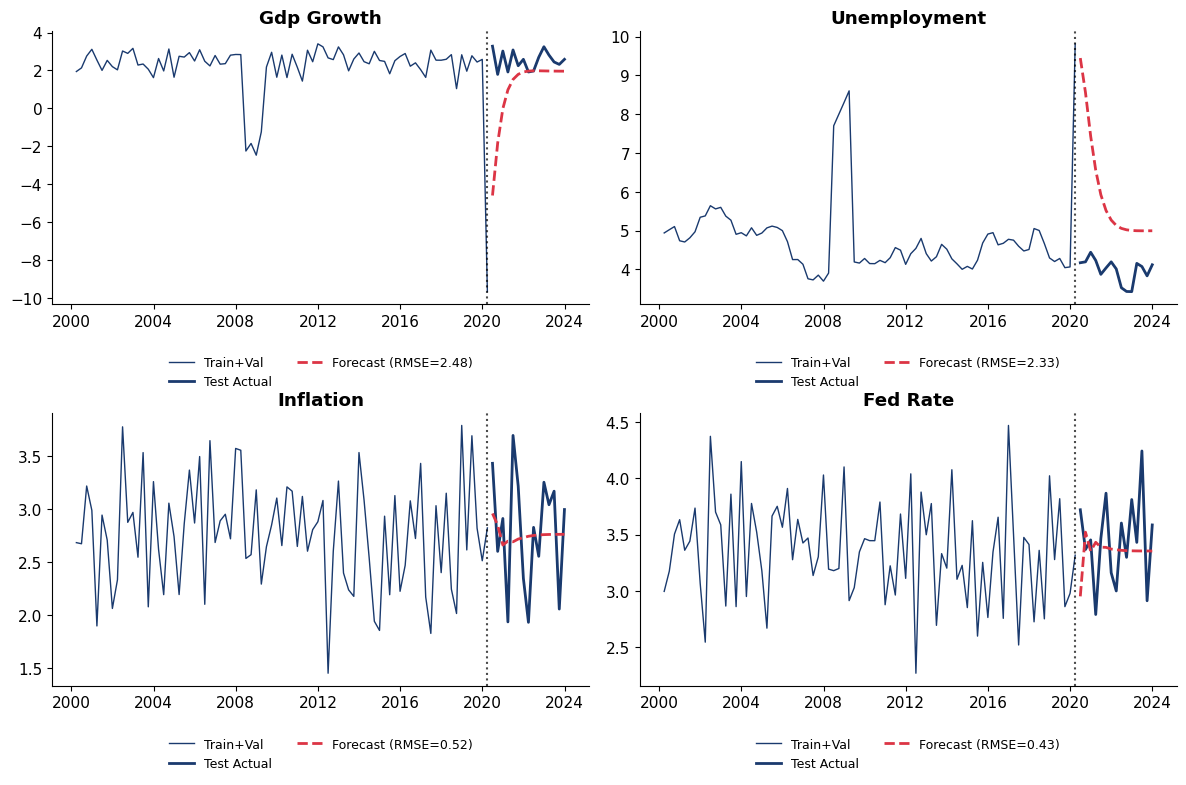

In [31]:
# Visualize VAR forecasts
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, (i, var) in zip(axes.flat, enumerate(econ_data.columns)):
    # Historical
    ax.plot(trainval_econ.index, trainval_econ[var], 
            color=COLORS['blue'], linewidth=1, label='Train+Val')
    # Test actual
    ax.plot(test_econ.index, test_econ[var], 
            color=COLORS['blue'], linewidth=2, label='Test Actual')
    # Forecast
    ax.plot(test_econ.index, test_forecast[:, i], 
            color=COLORS['red'], linewidth=2, linestyle='--', 
            label=f'Forecast (RMSE={test_var_metrics[var]["rmse"]:.2f})')
    ax.axvline(x=trainval_econ.index[-1], color='black', linestyle=':', alpha=0.7)
    ax.set_title(var.replace('_', ' ').title(), fontweight='bold')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()


IMPULSE RESPONSE FUNCTIONS
How does a shock to one variable affect others over time?



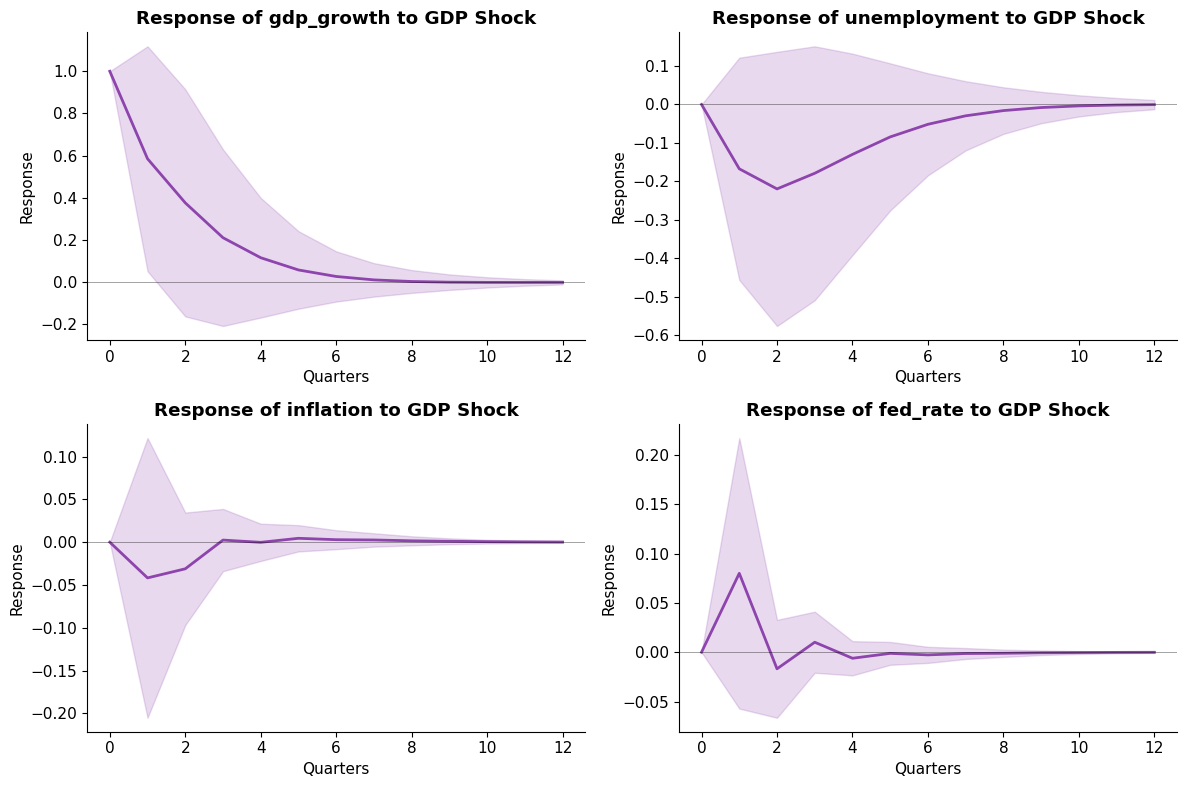

Interpretation:
- Positive GDP shock typically DECREASES unemployment (Okun's Law)
- Positive GDP shock may INCREASE inflation (demand-pull)
- Fed responds by RAISING rates to control inflation (Taylor Rule)


In [32]:
# Impulse Response Functions
print("\nIMPULSE RESPONSE FUNCTIONS")
print("="*60)
print("How does a shock to one variable affect others over time?\n")

irf = final_var_fitted.irf(periods=12)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot impulse responses to GDP shock
shock_var = 'gdp_growth'
shock_idx = list(econ_data.columns).index(shock_var)

for ax, (i, response_var) in zip(axes.flat, enumerate(econ_data.columns)):
    irf_values = irf.irfs[:, i, shock_idx]
    ax.plot(range(len(irf_values)), irf_values, color=COLORS['purple'], linewidth=2)
    ax.axhline(y=0, color='black', linewidth=0.5, alpha=0.5)
    ax.fill_between(range(len(irf_values)), 
                   irf.irfs[:, i, shock_idx] - 1.96 * irf.stderr()[:, i, shock_idx],
                   irf.irfs[:, i, shock_idx] + 1.96 * irf.stderr()[:, i, shock_idx],
                   alpha=0.2, color=COLORS['purple'])
    ax.set_title(f'Response of {response_var} to GDP Shock', fontweight='bold')
    ax.set_xlabel('Quarters')
    ax.set_ylabel('Response')

plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Positive GDP shock typically DECREASES unemployment (Okun's Law)")
print("- Positive GDP shock may INCREASE inflation (demand-pull)")
print("- Fed responds by RAISING rates to control inflation (Taylor Rule)")

In [33]:
print("\n" + "="*60)
print("CASE STUDY 4 SUMMARY: Multivariate VAR Analysis")
print("="*60)
print(f"Model: VAR({best_lag})")
print(f"Variables: GDP Growth, Unemployment, Inflation, Fed Rate")
print(f"\nTest Set Performance:")
for var, metrics in test_var_metrics.items():
    print(f"  {var:15s}: RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}")
print("\nKey Insights:")
print("- VAR captures dynamic relationships between economic variables")
print("- Granger causality reveals which variables lead/lag others")
print("- Impulse responses show how shocks propagate through the system")


CASE STUDY 4 SUMMARY: Multivariate VAR Analysis
Model: VAR(1)
Variables: GDP Growth, Unemployment, Inflation, Fed Rate

Test Set Performance:
  gdp_growth     : RMSE=2.4752, MAE=1.5002
  unemployment   : RMSE=2.3252, MAE=1.9458
  inflation      : RMSE=0.5202, MAE=0.4544
  fed_rate       : RMSE=0.4288, MAE=0.3458

Key Insights:
- VAR captures dynamic relationships between economic variables
- Granger causality reveals which variables lead/lag others
- Impulse responses show how shocks propagate through the system


---
# Summary: Complete Methodology

## Train/Validation/Test Framework

| Step | Purpose | Data Used |
|------|---------|----------|
| 1. Training | Estimate model parameters | 70% of data |
| 2. Validation | Select hyperparameters, compare models | 15% of data |
| 3. Test | Final unbiased evaluation | 15% of data (held out!) |

## Model Selection Summary

| Case Study | Data Type | Best Model | Key Feature |
|------------|-----------|------------|-------------|
| Bitcoin | Financial | GARCH | Volatility clustering |
| Sunspots | Long seasonal | ARIMA + Fourier | 11-year cycle |
| Unemployment | Structural break | Prophet | Changepoint detection |
| Economic | Multivariate | VAR | Cross-variable dynamics |

In [34]:
print("""
╔══════════════════════════════════════════════════════════════════════╗
║                    CHAPTER 10: KEY TAKEAWAYS                         ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  1. PROPER VALIDATION METHODOLOGY                                    ║
║     - NEVER peek at test data during model selection                 ║
║     - Use validation set for hyperparameter tuning                   ║
║     - Test set gives unbiased final performance estimate             ║
║                                                                      ║
║  2. MATCH MODEL TO DATA CHARACTERISTICS                              ║
║     - Financial data → GARCH for volatility                          ║
║     - Long seasonality → Fourier terms                               ║
║     - Structural breaks → Prophet/changepoints                       ║
║     - Multiple related series → VAR                                  ║
║                                                                      ║
║  3. INTERPRET RESULTS CAREFULLY                                      ║
║     - GARCH: Focus on volatility, not mean prediction                ║
║     - Granger causality ≠ true causality                             ║
║     - Confidence intervals matter for decision-making                ║
║                                                                      ║
║  4. PRACTICAL CONSIDERATIONS                                         ║
║     - Simple models often outperform complex ones                    ║
║     - Out-of-sample performance is what matters                      ║
║     - Always visualize data and residuals                            ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════╗
║                    CHAPTER 10: KEY TAKEAWAYS                         ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  1. PROPER VALIDATION METHODOLOGY                                    ║
║     - NEVER peek at test data during model selection                 ║
║     - Use validation set for hyperparameter tuning                   ║
║     - Test set gives unbiased final performance estimate             ║
║                                                                      ║
║  2. MATCH MODEL TO DATA CHARACTERISTICS                              ║
║     - Financial data → GARCH for volatility                          ║
║     - Long seasonality → Fourier terms                               ║
║     - Structural breaks → Prophet/changepoints                       ║
║     - Multiple related series → VAR             

---

## Data Sources

- **Bitcoin**: Yahoo Finance (BTC-USD)
- **Sunspots**: Wolfer sunspot dataset from statsmodels
- **US Unemployment**: Bureau of Labor Statistics via FRED (UNRATE)
- **Economic Data**: FRED (GDPC1, UNRATE, CPIAUCSL, FEDFUNDS)

---

**End of Chapter 10: Comprehensive Review**

*Course: Time Series Analysis and Forecasting*  
*Bucharest University of Economic Studies*